In [1]:
%cd /home/matej/prace/ferda/ferda_github

/home/matej/prace/ferda/ferda_github


In [2]:
!git rev-parse HEAD

6714facf2c2cf8119a0e9ee6cf684e96dc2c41a3


In [4]:
# !git checkout 6714facf2c2cf8119a0e9ee6cf684e96dc2c41a3

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import h5py
from imageio import imread
import numpy as np
import os
from os.path import join
import scripts.CNN.train_interactions as train_interactions
import pandas as pd
import warnings
pd.set_option('precision', 2)

In [10]:
DATA_DIR = '/home/matej/prace/ferda/data/interactions/1712_1k_36rot_fixed'
EXPERIMENT_DIR = '/home/matej/prace/ferda/experiments/171222_0124_batch_1k_36rot_fixed/'
SUB_EXPERIMENT = 0.428571428571
n_objects = 2

In [11]:
ti = train_interactions.TrainInteractions(n_objects)

In [23]:
y_test = pd.read_csv(join(DATA_DIR, 'test.csv'))    

with h5py.File(join(EXPERIMENT_DIR, str(SUB_EXPERIMENT), 'predictions.h5'), 'r') as hf:
    pred = hf['data'][:]
    pred_df = pd.DataFrame(ti.tostruct(pred))
    
loss_alpha_batch = pd.read_csv(join(EXPERIMENT_DIR, 'results.csv'))    

In [13]:
loss_alpha_batch[loss_alpha_batch['loss_alpha'] == SUB_EXPERIMENT]

,Unnamed: 0,xy MAE,angle MAE,loss_alpha
6,6,3.96,9.81,0.43


In [14]:
# loss_alpha_batch.loc[loss_alpha_batch.index[-1], 'xy MAE'] = np.nan
# xy = loss_alpha_batch['xy MAE']
# loss_alpha_batch['xy MAE norm'] = (xy - xy.mean()) / xy.std()
# #loss_alpha_batch['angle MAE'].iloc[0] = np.nan
# angle = loss_alpha_batch['angle MAE']
# loss_alpha_batch['angle MAE norm'] = (angle - angle.mean()) / angle.std()
# loss_alpha_batch['sum norm'] = loss_alpha_batch['angle MAE norm'] + loss_alpha_batch['xy MAE norm']
# loss_alpha_batch['alpha sum norm'] = loss_alpha_batch['angle MAE norm'] * (1 - loss_alpha_batch['loss_alpha']) + \
#                                      loss_alpha_batch['xy MAE norm'] * loss_alpha_batch['loss_alpha']

In [15]:
# ax = loss_alpha_batch.plot('loss_alpha', ['xy MAE norm', 'angle MAE norm', 'alpha sum norm'], 
#                            title='normalized mean absolute errors')
# ax.legend(['xy', 'angle', 'alpha weighted sum'])
# ax.set_xlabel('alpha')

/home/matej/.virtualenvs/ferda/lib/python2.7/site-packages/pandas/plotting/_core.py:1714: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


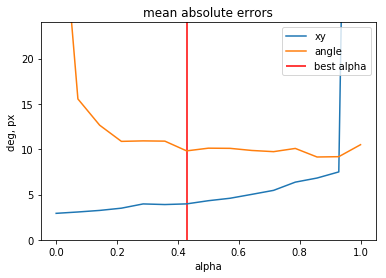

In [16]:
ax = loss_alpha_batch.plot('loss_alpha', ['xy MAE', 'angle MAE'], title='mean absolute errors')
ax.set_ylabel('deg, px')
ax.set_xlabel('alpha')
ax.set_ylim(0, 24)
ax.vlines(SUB_EXPERIMENT, ax.get_ylim()[0], ax.get_ylim()[1],
          'r')
ax.legend(['xy', 'angle', 'best alpha'])

# Predictions

In [17]:
pred_df.describe()

,0_x,0_y,0_major,0_minor,0_angle_deg,1_x,1_y,1_major,1_minor,1_angle_deg
count,3600.00,3600.00,3600.00,3600.00,3600.00,3600.00,3600.00,3600.00,3600.00,3600.00
mean,89.36,97.91,18.81,54.85,89.62,110.28,100.20,17.63,-28.00,-59.38
std,6.81,11.86,11.06,20.67,53.22,6.97,11.93,17.38,10.81,55.09
min,63.91,69.29,-6.68,-3.64,-38.06,93.52,70.99,-25.74,-63.49,-199.92
25%,84.78,88.87,10.42,41.62,48.62,105.04,91.17,4.26,-34.22,-105.00
50%,89.92,97.42,18.51,54.05,85.61,109.49,100.44,15.58,-27.66,-57.75
75%,94.31,106.90,25.19,67.71,131.86,115.14,108.61,29.28,-20.70,-15.46
max,107.39,129.49,66.15,124.36,217.88,131.97,131.66,71.11,10.81,77.19


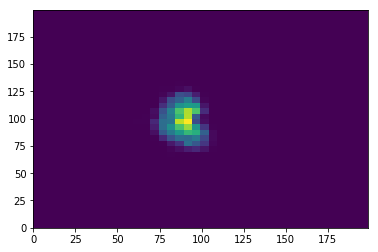

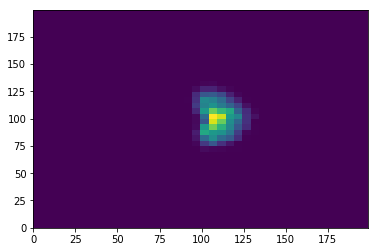

In [18]:
for i in range(n_objects):
    plt.figure()
    _ = plt.hist2d(pred_df['%d_x' % i], pred_df['%d_y' % i], bins=40, range=((0, 199), (0, 199)))

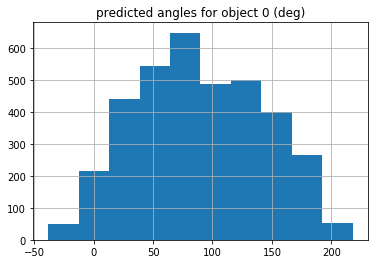

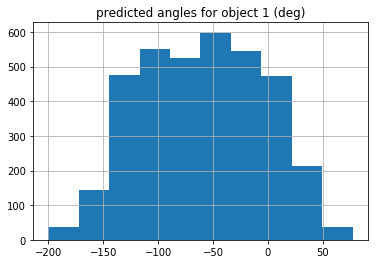

In [19]:
for i in range(n_objects):
    plt.figure()
    plt.title('predicted angles for object %d (deg)' % i)
    (pred_df['%d_angle_deg' % i]).hist()

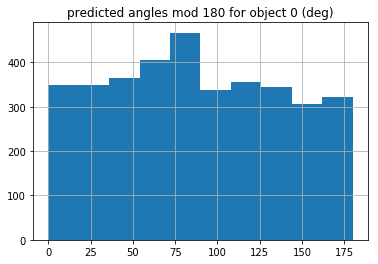

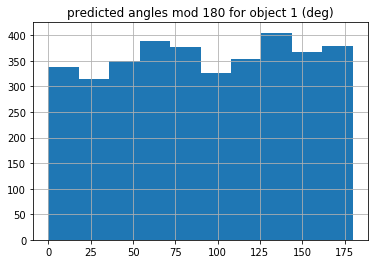

In [20]:
for i in range(n_objects):
    plt.figure()
    plt.title('predicted angles mod 180 for object %d (deg)' % i)
    (pred_df['%d_angle_deg' % i] % 180).hist()

# Prediction Errors

In [24]:
xy, angle, indices = ti.match_pred_to_gt(pred_df[ti.columns()].values, y_test[ti.columns()].values, np)
if n_objects == 1:
    xy_errors = xy
    angle_errors = angle
elif n_objects == 2:
    xy_errors = (xy[indices[:, 0], indices[:, 1]])
    angle_errors = (angle[indices[:, 0], indices[:, 1]])
else:
    assert False, 'not implemented'

In [25]:
df = pd.DataFrame.from_items([('xy (px)', [xy_errors.mean()]), 
                              ('angle (deg)', angle_errors.mean()),])
df.style.set_caption('MAE')
df

,xy (px),angle (deg)
0,3.96,9.81


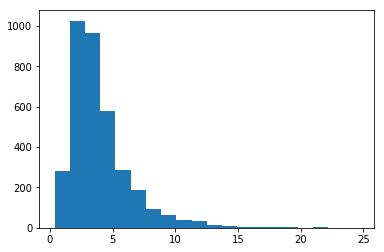

In [26]:
_  = plt.hist(xy_errors, 20)

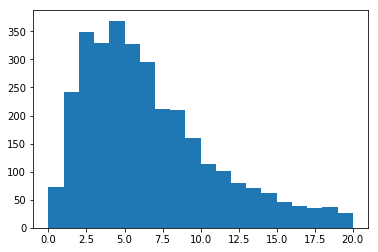

In [27]:
_ = plt.hist(angle_errors, 20, range=(0, 20))

# Model

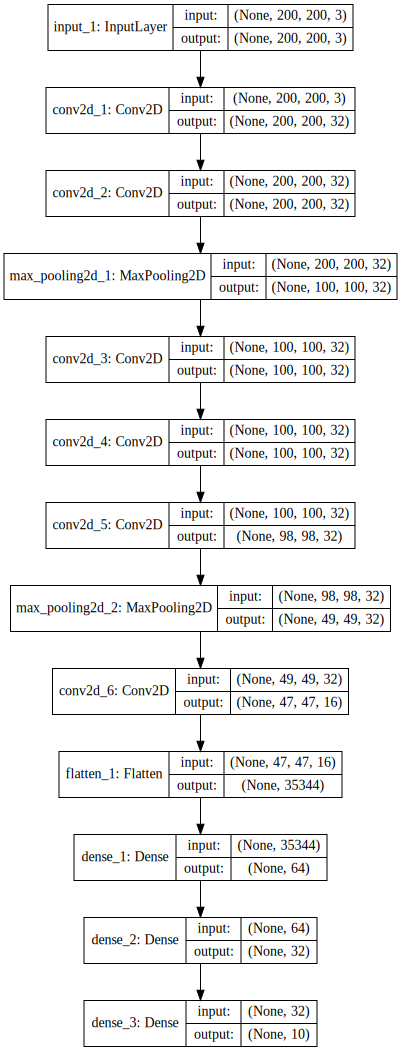

In [28]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(ti.model(), show_shapes=True).create(prog='dot', format='svg'))